# Cortical network model

Analysis of 3-population cortical network model with a focus on the effect of the synaptic strength on the network dynamics evoked by a stimulus

## Imports

In [1]:
%load_ext autoreload
%load_ext usnm2p.skip_kernel_extension
%autoreload 2

In [2]:
# External imports
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import jupyter_slack

# Internal modules
from usnm2p.logger import logger
from usnm2p.network_model import *
from usnm2p.utils import *
from usnm2p.fileops import get_data_root, load_lineagg_data, save_figs_book
from usnm2p.constants import *
from usnm2p.batchutils import *
from usnm2p.plotters import plot_table, harmonize_axes_limits
from usnm2p.postpro import get_fit_table, get_change_key, get_propagg_keys, compute_predictor, bin_by_quantile_intervals, free_expand
from usnm2p.model_params import *

# Initialize empty figures dictionary
figs = {}

# Set up logging folder
logdir = get_data_root(kind=DataRoot.MODEL)

### Input data parameters

In [3]:
# Parameters determining location of reference activity profiles
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
gcamp_key = get_gcamp_key(None)  # GCaMP key
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'

# Processing parameters
slack_notify = False   # notify start and completion on slack
run_state_dep = False  # Whether to run state-dependency analysis

### Dervied parameters

 2024/09/06 13:57:12: circuit model analysis notebook started on 2024-09-06 at 13:57:12
 2024/09/06 13:57:12: assembling batch analysis settings...


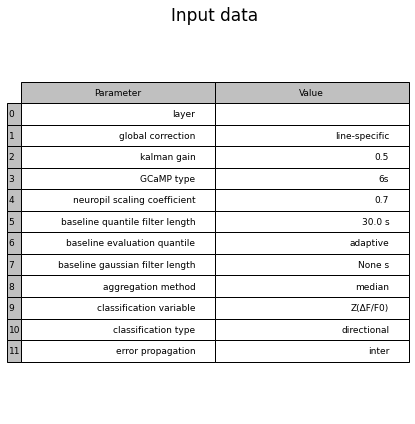

In [4]:
skip_state_dep = not run_state_dep  # Whether to skip state-dependency analysis

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'circuit model analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

# Get data input directory
_, input_dir, figsdir, _ = get_batch_settings(
    analysis_type, None, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Plot dataset info table
figs['dataset_info'] = plot_table({
    'layer': layer,
    'global correction': 'line-specific' if isinstance(global_correction, dict) else global_correction,
    'kalman gain': kalman_gain,
    'GCaMP type': gcamp_key,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Input data', aspect=1.5)

### Load data and compute raw response profiles

 2024/09/06 13:57:15: loading line-average data (with inter-propagated SE)
 2024/09/06 13:57:15: loading line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_stim-1->stimeverytrial/main folder
 2024/09/06 13:57:15: loading sst data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_stim-1->stimeverytrial/main folder
 2024/09/06 13:57:15: loading pv data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_stim-1->stimeverytrial/main folder
 2024/09/06 13:57:15: loading sarah_line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56

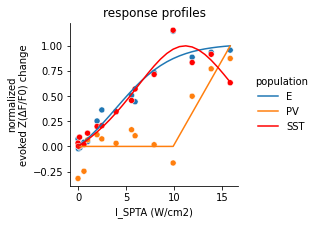

In [5]:
# Load line-aggregated stats
stats, counts = load_lineagg_data(input_dir, errprop=errprop)

# Restrict to 'all' responses
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats = (
    stats[isall]
    .droplevel(Label.ROI_RESP_TYPE)
    .reset_index(Label.RUN, drop=True)
)

# Extract data for responses of interest
xkey = Label.ISPTA
ykey = Label.ZSCORE
ykey_diff = get_change_key(ykey)
ykey_diff_prop = get_propagg_keys(ykey_diff)[0]
resp_data = (
    stats[[Label.ISPTA, ykey_diff_prop]]
    .rename(columns={ykey_diff_prop: ykey_diff})
    .set_index(Label.ISPTA, append=True)
    [ykey_diff]
)

# Fit response data
fit_dict = get_fit_table().loc[xkey]
predictors = {}
for pop, resp in resp_data.groupby(Label.LINE):
    predictors[pop] = compute_predictor(
        resp.droplevel(Label.LINE).index.values, 
        resp.values, 
        fit_dict.loc[pop])

# Compute fit profiles over dense input range
xbounds = np.sort(resp_data.index.unique(xkey))[[0, -1]]
xdense = np.linspace(*xbounds, 25).round(3)
resp_profiles = pd.DataFrame(index=pd.Index(xdense, name=xkey))
for pop, pred in predictors.items():
    resp_profiles[pop] = pred(xdense)
resp_profiles = (
    resp_profiles
    .stack()
    .rename_axis(index={None: Label.LINE})
    .swaplevel()
    .sort_index()
    .rename(ykey_diff)
)

# Apply lines->populations mapping
newobjs = []
for s in resp_profiles, resp_data:
    s = s.reset_index(level=Label.LINE)
    s[Label.LINE] = s[Label.LINE].str.replace('line3', 'e').str.upper()
    s['population'] = s.pop(Label.LINE)
    s = s.set_index('population', append=True).swaplevel().sort_index()[ykey_diff]
    newobjs.append(s)
resp_profiles, resp_data = newobjs

# Normalize response data
logger.info('normalizing predictors to [0, 1] range')
resp_bounds = resp_profiles.abs().groupby('population').agg(['min', 'max'])#.droplevel(0, axis=0)
resp_ranges = resp_bounds.diff(axis=1).iloc[:, 1].rename('range')
ykey_diff = f'normalized\n{ykey_diff}'
resp_data = ((resp_data - resp_bounds['min']) / resp_ranges).rename(ykey_diff)
resp_profiles = ((resp_profiles - resp_bounds['min']) / resp_ranges).rename(ykey_diff)

# Plot response profiles
figs['resp_profiles'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
pltkwargs = dict(
    ax=ax,
    x=xkey, 
    y=ykey_diff,
    hue='population',
    palette=NetworkModel.palette,
)
sns.scatterplot(data=resp_data.reset_index(), legend=False, **pltkwargs)
sns.lineplot(data=resp_profiles.reset_index(), **pltkwargs)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.set_title('response profiles')

# Save response profiles to file (if not already saved)
ref_profiles = resp_profiles.unstack('population').round(3)
logger.info('saving reference profiles to CSV file')
ref_fpath = os.path.join(logdir, 'ref_profiles.csv')
if not os.path.exists(ref_fpath):
    ref_profiles.to_csv(ref_fpath)

# Extract input amplitudes from reference profiles
amps = ref_profiles.index.values

## Literature review

 2024/09/06 13:57:17: initialized NetworkModel(E, PV, SST)
 2024/09/06 13:57:17: initialized NetworkModel(E, PV, SST)
 2024/09/06 13:57:17: initialized NetworkModel(E, PV, SST)
 2024/09/06 13:57:18: initialized NetworkModel(E, PV, SST)


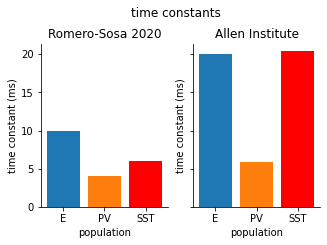

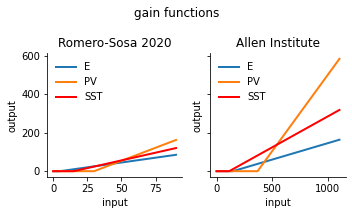

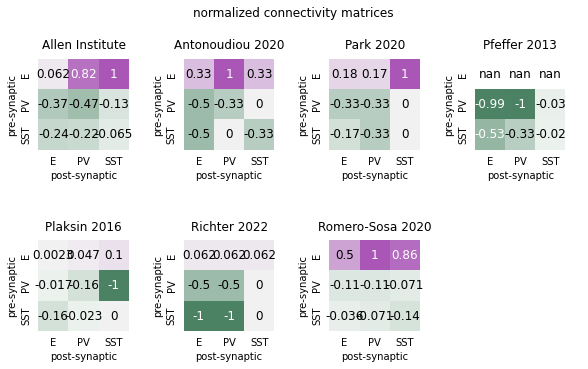

In [6]:
# Firing rate adaptation time constants 
figs['litreview tau'], axes = plt.subplots(
    1, len(tau_dict), figsize=(2.5 * len(tau_dict), 3), sharey=True)
figs['litreview tau'].suptitle('time constants', y=1.05)
for ax, (key, t) in zip(axes, tau_dict.items()):
    NetworkModel(tau=t).plot_time_constants(ax=ax)
    ax.set_title(key)

# Gain function parameters
figs['litreview fgains'], axes = plt.subplots(
    1, len(fparams_dict), figsize=(2.5 * len(fparams_dict), 3), sharey=True)
figs['litreview fgains'].suptitle('gain functions')
for ax, (key, fp) in zip(axes, fparams_dict.items()):
    NetworkModel(fparams=fp).plot_fgain(ax=ax)
    ax.set_title(key)

# Connectivity matrices
figs['litreview W'] = NetworkModel.plot_connectivity_matrix(W_dict, norm=True)

## 3-population (E, SST, PV) model

### Initialize model

 2024/09/06 13:57:22: initialized NetworkModel(E, PV, SST)


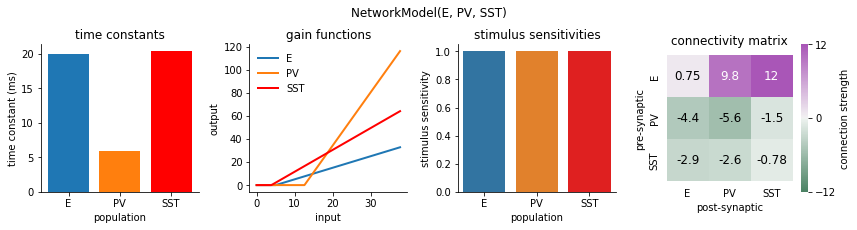

In [7]:
# Initialize model
source_key = 'Allen Institute'
Wref = W_dict[source_key]
tau_ref = tau_dict[source_key]
fparamsref = fparams_dict[source_key]
Wref_rescaled = NetworkModel.rescale_W(Wref)
fparamsref_rescaled = NetworkModel.rescale_fparams(fparamsref)
model = NetworkModel(
    W=Wref_rescaled,
    tau=tau_dict[source_key], 
    fparams=fparamsref_rescaled,
)

# Plot model summary
figs['initial model'] = model.plot_summary()    

### Optimize model parameters for different sets of constraints

 2024/09/06 14:12:20: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparamsd39e3333a72ddb661bc5db06c44d4b9d_tauE20.01PV5.93SST20.36_targetsb4642db64f6b772a4c30fb6f24609513_wbounds5b6689c62f8cd9efc3033dee160fa191_srelbounds0.0-5.0_diffev_norm_xdisp0.001_xwdev0.1_unisrel_rerun4.csv
 2024/09/06 14:12:21: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparamsd39e3333a72ddb661bc5db06c44d4b9d_tauE20.01PV5.93SST20.36_targetsb4642db64f6b772a4c30fb6f24609513_wbounds5b6689c62f8cd9efc3033dee160fa191_srelbounds0.0-5.0_diffev_norm_xdisp0.001_xwdev0.1_unisrel_rerun2.csv
 2024/09/06 14:12:22: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparamsd39e3333a72ddb661bc5db06c44d4b9d_tauE20.01PV5.93SST20.36_targetsb4642db64f6b772a4c30fb6f24609513_wbounds5b6689c62f8cd9efc3033dee160fa191_srelbounds0.0-5.0_diffev_norm_xdisp0.001_xwdev0.1_unisrel_rerun3.cs

100%|██████████| 25/25 [00:00<00:00, 41.51it/s]


 2024/09/06 14:12:32: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 36.90it/s]


 2024/09/06 14:12:34: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 45.39it/s]


 2024/09/06 14:12:36: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 41.70it/s]


 2024/09/06 14:12:38: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 42.79it/s]


 2024/09/06 14:12:41: comparison error (RMSE): 
mean    0.459520
sem     0.015526
Name: error, dtype: float64
 2024/09/06 14:12:41: W relative absolute deviation from reference (%):
min      13.829048
mean     68.591346
sem      32.945969
max     328.263333
dtype: float64
 2024/09/06 14:12:41: stimulus sensitivity:
population         E        PV       SST
mean        1.921350  1.921350  1.921350
sem         0.226066  0.226066  0.226066
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

E vs. PV: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.250e+01
PV vs. SST: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.250e+01
E vs. SST: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.250e+01
 2024/09/06 14:12:42: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparamsd39e3

100%|██████████| 25/25 [00:00<00:00, 33.40it/s]


 2024/09/06 14:12:54: running stimulation sweep


100%|██████████| 25/25 [00:01<00:00, 18.05it/s]


 2024/09/06 14:12:57: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 29.90it/s]


 2024/09/06 14:13:00: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 32.72it/s]


 2024/09/06 14:13:02: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 32.03it/s]


 2024/09/06 14:13:05: comparison error (RMSE): 
mean    0.084415
sem     0.001821
Name: error, dtype: float64
 2024/09/06 14:13:05: W relative absolute deviation from reference (%):
min      0.056347
mean     4.637861
sem      2.531571
max     18.299977
dtype: float64
 2024/09/06 14:13:05: stimulus sensitivity:
population         E        PV       SST
mean        3.724360  3.216641  0.563659
sem         0.093534  0.062795  0.068306
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

E vs. PV: Mann-Whitney-Wilcoxon test two-sided, P_val:1.587e-02 U_stat=2.400e+01
PV vs. SST: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=2.500e+01
E vs. SST: Mann-Whitney-Wilcoxon test two-sided, P_val:7.937e-03 U_stat=2.500e+01


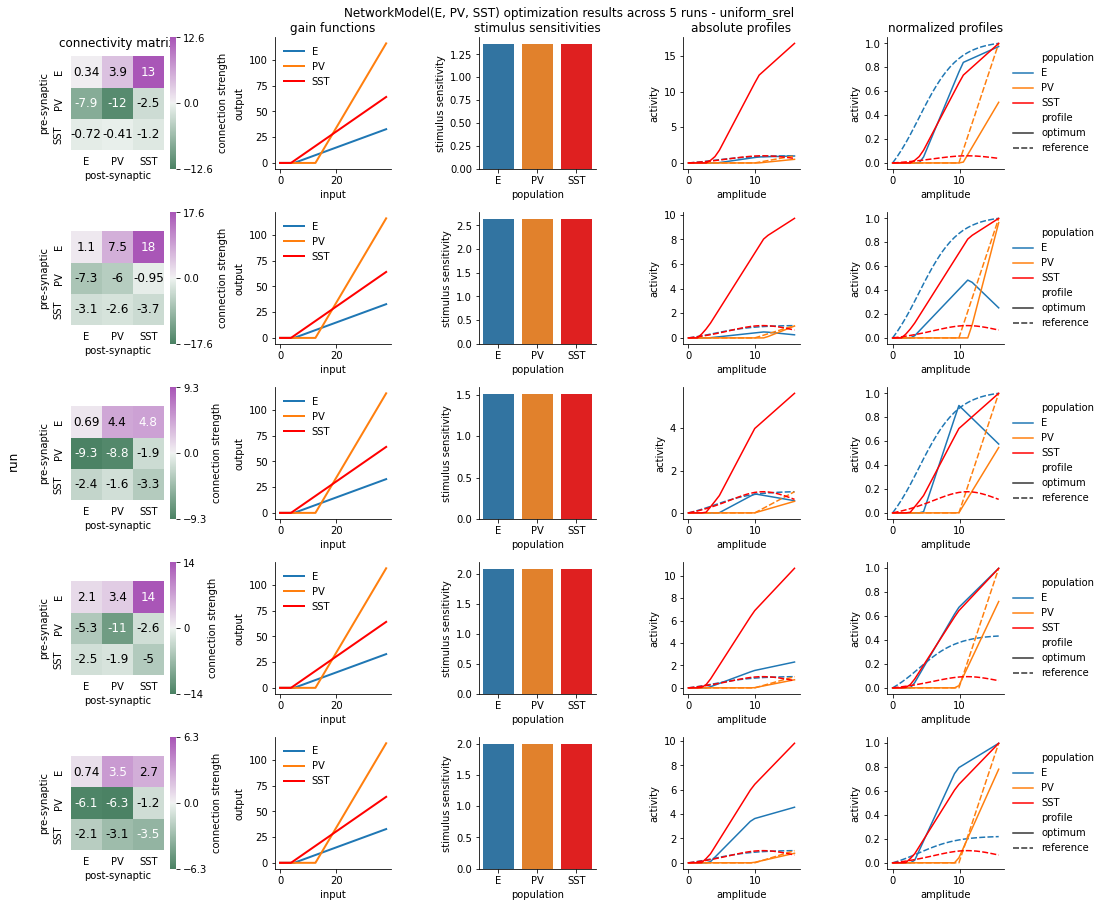

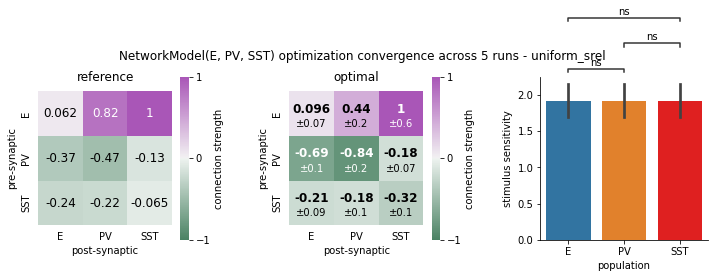

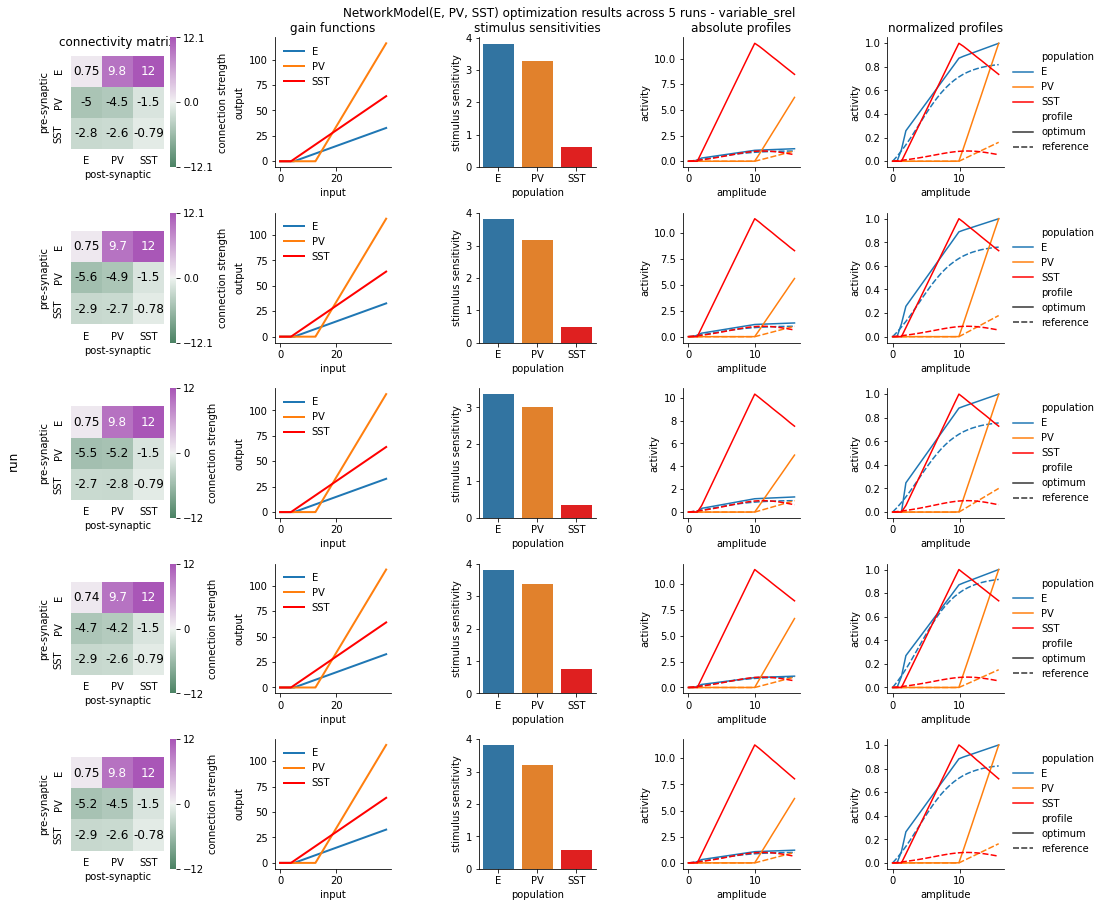

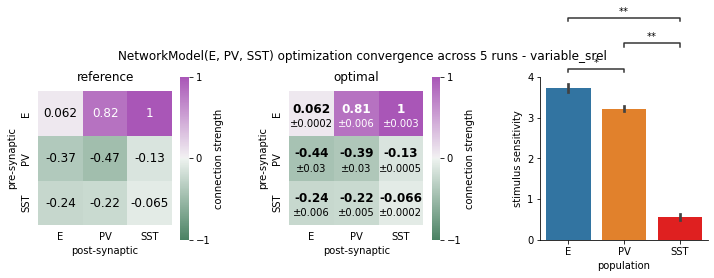

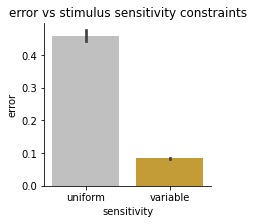

In [21]:
# Define model evaluation/optimization parameters
norm = True  # whether to normalize activation profiles
disparity_cost_factor = 1e-3 # scaling factor for disparity cost
Wbounds = model.get_coupling_bounds(wmax=20)  # connectivity matrix exploration bounds
Wdev_cost_factor = 0.1  # scaling factor for network deviation cost
srel_bounds = (0, 5)  # stimulus sensitivity exploration bounds
srel_dists = {
    'uniform': True,
    'variable': False,
}
errors_vs_srel = {}
Woptavg_vs_srel = {}
srel_opt_avg_vs_srel = {}

# For both uniform and variable stimulus sensitivity
for srel_key, uniform_srel in srel_dists.items():

    suffix = f'{srel_key}_srel'

    # Define optimization parameters
    optargs, optkwargs = (
        [model, ref_profiles],
        dict(
            norm=norm, 
            disparity_cost_factor=disparity_cost_factor,
            Wdev_cost_factor=Wdev_cost_factor,
            logdir=logdir,
            mpi=True,
            Wbounds=Wbounds,
            srel_bounds=srel_bounds,
            uniform_srel=uniform_srel,
        )
    )

    # # Optimize model parameters to minimize divergence with reference profiles
    # optres = ModelOptimizer.optimize(*optargs, **optkwargs)

    # Load optimization history and assess optimization convergence
    histories = ModelOptimizer.load_optimization_history(*optargs, **optkwargs)
    if 'run' not in histories.index.names:
        histories = pd.concat({0: histories}, names=['run'])
    has_converged = ModelOptimizer.has_optimization_converged(histories)
    for irun, converged in has_converged.items():
        if not converged:
            logger.warning(f'optimization did not converge for run {irun}')

    # Extract optimum parameters from each run and associated cost
    optimums = ModelOptimizer.extract_optimum(histories)

    # Create figure
    figkey = 'opt results' + suffix
    nruns = len(optimums)
    ncols = 5
    figs[figkey], axes = plt.subplots(nruns, ncols, figsize=(3 * ncols, 2.5 * nruns))
    axes = np.atleast_2d(axes)

    # For each run, perform stimulus sweep with optimal connectivity matrix
    errors = pd.Series(index=optimums.index, name='error')
    for irow, (axrow, (irun, optvec)) in enumerate(zip(axes, optimums.groupby('run'))):
        opt = model.parse_optimum_vector(optvec.iloc[0])
        if 'W' in opt:
            model.W = opt['W']
        if 'srel' in opt:
            model.srel = opt['srel']
        
        sweep_data = model.run_stim_sweep(amps)
        sweep_rss = model.extract_response_magnitude(sweep_data)

        # Compare results to reference profiles
        error = model.evaluate_stim_sweep(
            ref_profiles, sweep_data, norm=norm)
        sweep_comp = pd.concat({
            'optimum': sweep_rss,
            'reference': ref_profiles
        }, axis=0, names=['profile'])

        # Plot results
        axtitle = None if irow == 0 else ''
        model.plot_connectivity_matrix(W=model.W, ax=axrow[0], title=axtitle)
        model.plot_fgain(ax=axrow[1], title=axtitle)
        model.plot_stimulus_sensitivity(ax=axrow[2], title=axtitle)
        for ax, n in zip(axrow[3:], [False, 'ax']):
            model.plot_sweep_results(sweep_comp, norm=n, ax=ax, style='profile')
            if irow == 0:
                ax.set_title(f'{"normalized" if n else "absolute"} profiles')
            if not n:
                ax.get_legend().remove()
            if n == norm:
                ax.text(0.1, 0.9, f'error = {error:.2f}', transform=ax.transAxes, ha='left', va='top')
        sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

        errors.loc[irun] = error

    # Harmonize axes limits for absolute profiles
    harmonize_axes_limits(axes[:, 1], 'y')

    # Adjust layout
    figs[figkey].tight_layout()
    figs[figkey].supylabel('run', x=-0.02)
    figs[figkey].subplots_adjust(wspace=.75)
    figs[figkey].suptitle(f'{model} optimization results across {nruns} runs - {suffix}', y=1 + 0.02 / nruns)

    # Log error statistics
    error_stats = errors.agg(['mean', 'sem'])
    logger.info(f'comparison error (RMSE): \n{error_stats}')
    errors_vs_srel[srel_key] = errors

    # Create "convergence" figure showing aggregate convergence parameters across runs
    naxes_conv = 1
    if Wbounds is not None:
        naxes_conv += 1
    if srel_bounds is not None:
        naxes_conv += 1
    figs['convergence' + suffix], axes = plt.subplots(1, naxes_conv, figsize=(4 * naxes_conv, 3))
    axiter = iter(axes)

    # Plot reference connectivity matrix
    model.plot_connectivity_matrix(Wref, ax=next(axiter), title='reference')

    # Plot aggregate connectivity matrix across runs, if available
    if Wbounds is not None:
        Wopts = {k: model.parse_optimum_vector(v)['W'] for k, v in optimums.items()}
        Wopts = pd.concat(Wopts, names=['run'])
        model.plot_connectivity_matrix(Wopts, agg=True, ax=next(axiter), title='optimal', norm=True)

        # Compute average W across runs
        Woptavg = Wopts.groupby('pre-synaptic').mean()
        Woptavg_vs_srel[srel_key] = Woptavg

        # Compute average W relative deviation from reference
        Wreldev = (Woptavg - Wref_rescaled) / Wref_rescaled
        Wreldev_stats = Wreldev.abs().stack().agg(['min', 'mean', 'sem', 'max'])
        logger.info(f'W relative absolute deviation from reference (%):\n{Wreldev_stats * 1e2}')

    # Plot similarity between stimulus sensitivities from different runs, if available
    if srel_bounds is not None:
        srel_opts = {k: model.parse_optimum_vector(v)['srel'] for k, v in optimums.items()}
        srel_opts = pd.concat(srel_opts, names=['run'])
        srel_opts_stats = srel_opts.unstack().agg(['mean', 'sem'])
        logger.info(f'stimulus sensitivity:\n{srel_opts_stats}')
        srel_opt_avg = srel_opts.groupby('population').mean()
        model.plot_stimulus_sensitivity(srel_opts, title='', ax=next(axiter))
        srel_opt_avg_vs_srel[srel_key] = srel_opt_avg
    
    figs['convergence' + suffix].suptitle(f'{model} optimization convergence across {nruns} runs - {suffix}', y=1 + 0.02 / nruns)

# Plot error statistics vs constraint options
errors_vs_srel = pd.concat(errors_vs_srel, names=['sensitivity'])
figs['opt error'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
ax.set_title('error vs stimulus sensitivity constraints')
sns.barplot(
    ax=ax,
    data=errors_vs_srel.reset_index(),
    y='error',
    x='sensitivity',
    palette={'uniform': 'silver', 'variable': 'goldenrod'},
    errorbar='se',
);

### Simulate average optimal model

 2024/09/06 13:58:20: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 41.55it/s]


 2024/09/06 13:58:21: running stimulation sweep


100%|██████████| 3/3 [00:00<00:00, 39.27it/s]

 2024/09/06 13:58:22: running stimulation sweep



100%|██████████| 25/25 [00:00<00:00, 32.44it/s]


 2024/09/06 13:58:23: running stimulation sweep


100%|██████████| 3/3 [00:00<00:00, 28.57it/s]


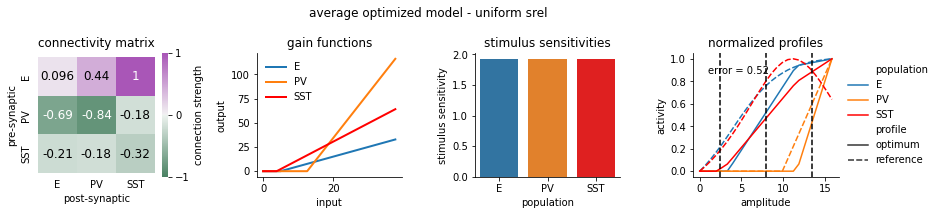

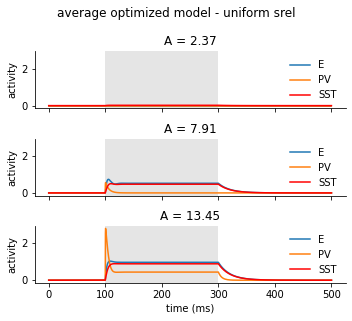

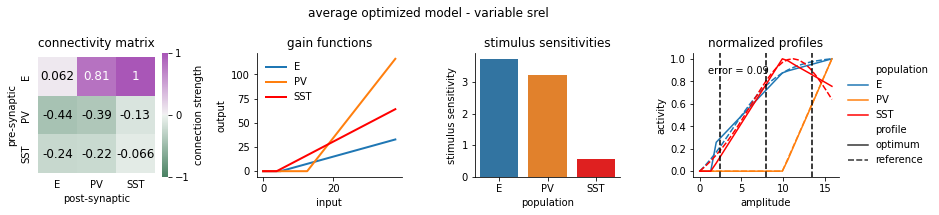

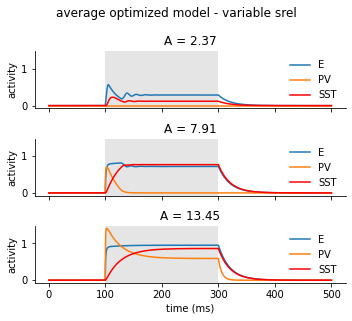

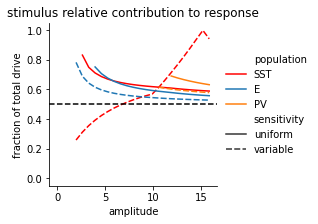

In [9]:
# Create dictionary to store relative stimulus drive contribution(s)
rel_stim_drive_vs_srel = {}

# For each set of optimization constraints
for srel_key in srel_dists.keys():

    # Assign average optimum parameters to model
    model.W = Woptavg_vs_srel[srel_key]
    model.srel = srel_opt_avg_vs_srel[srel_key]

    # Run simulation sweep across input amplitudes
    sweep_data = model.run_stim_sweep(amps)
    sweep_rss = model.extract_response_magnitude(sweep_data)
    maxperpop = sweep_rss.max()

    # Compare results to reference profiles
    error = model.evaluate_stim_sweep(
        ref_profiles, sweep_data, norm=norm)
    sweep_comp = pd.concat({
        'optimum': sweep_rss,
        'reference': ref_profiles
    }, axis=0, names=['profile'])

    # Plot results
    figkey = f'optavg sweep comp {srel_key}'
    figs[figkey], axes = plt.subplots(1, 4, figsize=(12, 3))
    figs[figkey].suptitle(f'average optimized model - {srel_key} srel')
    model.plot_connectivity_matrix(W=model.W / model.W.abs().max().max(), ax=axes[0])
    model.plot_fgain(ax=axes[1])
    model.plot_stimulus_sensitivity(ax=axes[2])
    sweepax = axes[3]
    model.plot_sweep_results(sweep_comp, norm='style', ax=sweepax, style='profile')
    sweepax.set_title(f'{"normalized" if norm else "absolute"} profiles')
    sweepax.text(0.1, 0.9, f'error = {error:.2f}', transform=sweepax.transAxes, ha='left', va='top')
    sns.move_legend(sweepax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

    # Plot detailed simulation results for a set of characteristic input amplitudes
    amp_range = amps.max() - amps.min()
    amps_sparse = np.linspace(amps.min() + 0.15 * amp_range, amps.max() - 0.15 * amp_range, 3)
    sweep_data_sparse = model.run_stim_sweep(amps_sparse)
    if norm:
        sweep_data_sparse[POPULATIONS] /= maxperpop
    figkey = f'optavg timeseries {srel_key}'
    figs[figkey], axes = plt.subplots(
        amps_sparse.size, 1, figsize=(5, 1.5 * amps_sparse.size), 
        sharex=True, sharey=True)
    figs[figkey].suptitle(f'average optimized model - {srel_key} srel')
    for (A, sol), ax in zip(sweep_data_sparse.groupby('amplitude'), axes):
        sweepax.axvline(A, color='k', linestyle='--')
        model.plot_timeseries(sol.droplevel('amplitude'), title=f'A = {A:.2f}', axes=ax, plot_stimulus=False)

    # Compute steady-state presynaptic and stimulus drives over input amplitudes range 
    presyn_drive = model.compute_drive(sweep_rss).abs()
    stim_drive = pd.DataFrame(
        data=np.outer(sweep_rss.index, model.srel),
        index=sweep_rss.index,
        columns=model.idx,
    )

    # Compute relative contribution of stimulus drive to evoked responses
    rel_stim_drive = stim_drive / (stim_drive + presyn_drive)
    rel_stim_drive = rel_stim_drive.where(sweep_rss > 1e-2)
    rel_stim_drive = rel_stim_drive.stack().rename('fraction of total drive')
    rel_stim_drive_vs_srel[srel_key] = rel_stim_drive

# Plot relative stimulus drive contribution for each set of constraints
rel_stim_drive_vs_srel = pd.concat(rel_stim_drive_vs_srel, names=['sensitivity'])
figs['rel stim contr.'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
ax.set_title('stimulus relative contribution to response')
sns.lineplot(
    ax=ax,
    data=rel_stim_drive_vs_srel.reset_index(),
    x='amplitude',
    y=rel_stim_drive.name,
    hue='population',
    palette=model.palette,
    style='sensitivity',
)
ax.set_ylim(-0.05, 1.05)
ax.axhline(0.5, color='k', linestyle='--')
ax.set_xlim(-0.05 * amps.max(), 1.05 * amps.max())
sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False);

### Simulate "disconnected" optimal models to obtain intrinsic response curves

 2024/09/06 13:58:28: initialized NetworkModel(E, PV, SST)
 2024/09/06 13:58:28: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 39.04it/s]


 2024/09/06 13:58:30: initialized NetworkModel(E, PV, SST)
 2024/09/06 13:58:30: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 35.56it/s]


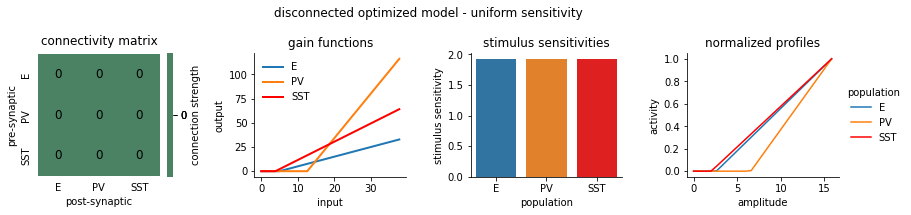

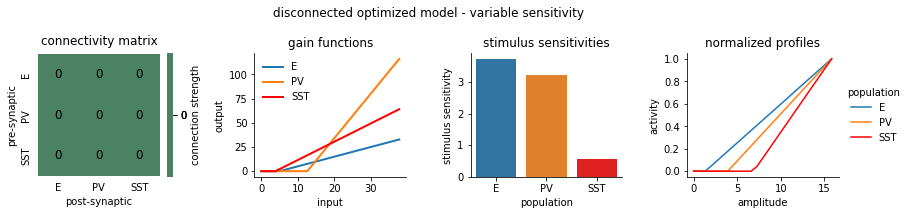

In [10]:
# For each set of optimization constraints
for srel_key in srel_dists.keys():
    
    # Create "disconnected" copy of model with null connectivity matrix
    disconnected_model = model.copy().disconnect()
    disconnected_model.srel = srel_opt_avg_vs_srel[srel_key]

    # Run simulation sweep across input amplitudes
    sweep_data = disconnected_model.run_stim_sweep(amps)
    sweep_rss = disconnected_model.extract_response_magnitude(sweep_data)

    # Plot results
    figkey = f'optavg disconnected model - {srel_key} srel'
    figs[figkey], axes = plt.subplots(1, 4, figsize=(12, 3))
    figs[figkey].suptitle(f'disconnected optimized model - {srel_key} sensitivity')
    disconnected_model.plot_connectivity_matrix(
        W=disconnected_model.W, ax=axes[0])
    disconnected_model.plot_fgain(ax=axes[1])
    disconnected_model.plot_stimulus_sensitivity(ax=axes[2])
    sweepax = axes[3]
    disconnected_model.plot_sweep_results(sweep_rss, norm=norm, ax=sweepax)
    sweepax.set_title(f'{"normalized" if norm else "absolute"} profiles')
    sns.move_legend(sweepax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

## State-dependency analysis

### Orthogonal explorations (varying 1 population baseline at a time)

In [11]:
%%skip $skip_state_dep

# Assign average optimum parameters to model
srel_key = 'variable'
model.W = Woptavg_vs_srel[srel_key]
model.srel = srel_opt_avg_vs_srel[srel_key]

# Initialize baseline drives to zero
model.b = pd.Series(index=pd.Index(POPULATIONS, name='population'), data=0)

# Run simulation sweep across input amplitudes and extract max ss-activity per population
logger.info('computing reference profiles')
sweep_data = model.run_stim_sweep(amps)
sweep_rss = model.extract_response_magnitude(sweep_data)
maxperpop = sweep_rss.max()

# Create figure backbone
figkey = 'optavg sweep vs baseline'
figs[figkey], sweepaxes = plt.subplots(1, len(POPULATIONS), figsize=(4 * len(POPULATIONS), 3))
figs[figkey].suptitle(f'{"normalized" if norm else "absolute"} profiles vs. baseline drive, per population', y=1.05)

# Set arbitrary baseline drives to each population
# rel_bdrives = np.linspace(0, 2, 5)
# rel_bdrives = dict(zip([f'{x:.2f}' for x in rel_bdrives], rel_bdrives))
rel_bdrives = {'low': 0., 'mid': .25, 'high': .5}
# beq = model.srel * amps.max()
beq = model.find_baseline_drives(maxperpop)

for (pop, bmax), sweepax in zip(beq.items(), sweepaxes):
    sweep_rss_vs_state = {}

    # Initialize figure for detailed simulation results
    fig, axes = plt.subplots(
        len(rel_bdrives), amps_sparse.size, 
        figsize=(3 * amps_sparse.size, 2 * len(rel_bdrives))
    )
    fig.suptitle(f'activity vs {pop}_drive')

    # Run simulation sweep for each baseline drive
    for (k, relb), axrow in zip(rel_bdrives.items(), axes):
        logger.info(f'{pop} population, {k} baseline drive')
        # Set population baseline drive
        model.b.loc[pop] = relb * bmax

        # Compute expected baseline activity in each population for that drive
        baseline_ss = model.compute_steady_state()

        # Run simulation sweep across input amplitudes
        sweep_data = model.run_stim_sweep(amps)
        sweep_rss = model.extract_response_magnitude(sweep_data, metric='ss')
        sweep_rss_vs_state[k] = sweep_rss

        # Plot detailed simulation results for a set of characteristic input amplitudes
        amp_range = amps.max() - amps.min()
        amps_sparse = np.linspace(amps.min() + 0.15 * amp_range, amps.max() - 0.15 * amp_range, 3)
        sweep_data_sparse = model.run_stim_sweep(amps_sparse)
        # del sweep_data_sparse['x']
        if norm:
            sweep_data_sparse[POPULATIONS] /= maxperpop
            baseline_ss /= maxperpop

        prefix = f'{pop}_drive = {model.b.loc[pop]:.2f}'
        for (A, sol), ax in zip(sweep_data_sparse.groupby('amplitude'), axrow):
            model.plot_timeseries(sol.droplevel('amplitude'), title=f'{prefix}, A = {A:.2f}', axes=ax, plot_stimulus=False)
            for pkey, pval in baseline_ss.items():
                ax.axhline(pval, color=model.palette[pkey], linestyle='--')

    harmonize_axes_limits(axes.ravel(), 'y')
    for ax in axes.ravel()[1:]:
        ax.legend().remove()

    # Reset baseline drive to zero
    model.b.loc[pop] = 0.

    # Assemble results into DataFrame
    sweep_rss_vs_state = pd.concat(sweep_rss_vs_state, names=['state'])

    # Plot results
    model.plot_sweep_results(
        sweep_rss_vs_state[[pop]], 
        norm='ax',
        ax=sweepax,
        style='state', style_order=rel_bdrives.keys()
    )
    sweepax.set_title(f'responses vs. {pop} state')

for sweepax in sweepaxes[:-1]:
    sweepax.legend().remove()
sns.move_legend(sweepaxes[-1], bbox_to_anchor=(1, .5), loc='center left', frameon=False)

### Combined explorations (varying all population baselines and binning final results)

In [12]:
%%skip $skip_state_dep

# Set number of random combinations to generate
ncombinations = 1000

# Determine bounds for baselines drives for each population
beq = model.find_baseline_drives(maxperpop)

# Generate random combinations of baseline drives for each population
baselines = pd.DataFrame(
    data=np.random.uniform(0, 1, size=(ncombinations, len(POPULATIONS))),
    columns=beq.index
) * beq
baselines.index.name = 'combination'

# Simulate model for each combination of baseline drives to get response profiles
states = {}
responses = {}
# Catch all warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for icomb, baseline in tqdm(baselines.iterrows()):
        model.b = baseline
        states[icomb] = model.compute_steady_state()
        sweep_data = model.run_stim_sweep(amps, verbose=False)
        responses[icomb] = model.extract_response_magnitude(sweep_data)
responses = pd.concat(responses, names=['combination'])
states = pd.concat(states, names=['combination'], axis=1).T

# Bin states by quantile intervals
nbins = 2
binned_states = pd.concat(
    {k: bin_by_quantile_intervals(states, k, nbins=nbins, add_aggregate=False)
     for k in states.columns},
    axis=1,
    names=['population']
)
# binned_states = binned_states.map(mapper)
fig, axes = plt.subplots(1, len(POPULATIONS), figsize=(3 * len(POPULATIONS), 3))

# Normalize responses to [0, 1] range for each population
avgmaxperpop = (
    responses.groupby('combination')
    .agg(lambda x: x.abs().max())
    .mean()
)
normresponses = responses / avgmaxperpop

# For each population, plot response profile as a function of state category
for k, ax in zip(POPULATIONS, axes):
    sns.despine(ax=ax)
    ax.set_title(f'{k} state-dep')
    tmpdf = pd.concat([
        free_expand(binned_states[k].rename('state'), normresponses),
        normresponses[k].rename('response'),
    ], axis=1)
    sns.lineplot(
        data=tmpdf.reset_index(),
        x='amplitude',
        y='response',
        # units='combination', estimator=None, alpha=0.5,
        estimator='mean',
        errorbar='se',
        hue='state',
        hue_order=['low', 'high'],
        palette={'low': 'dimgray', 'high': 'goldenrod'},
        ax=ax,
        legend=ax is axes[-1]
    )
sns.move_legend(axes[-1], bbox_to_anchor=(1, .5), loc='center left', frameon=False)
fig.tight_layout()

### Save figures

In [13]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix='network_model')

 2024/09/06 13:58:36: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.09.06/figs_network_model.pdf:


100%|██████████| 18/18 [00:11<00:00,  1.59it/s]


### Notify upon completion

In [16]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'circuit model analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/09/06 14:00:30: circuit model analysis notebook completed in 0:03:17.815912 s
